In [28]:
# got through the bayesian network football strength predictor
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [29]:
import os
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, HTML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc 

In [30]:
DATA_DIR = os.path.join(os.getcwd(), 'data/')
CHART_DIR = os.path.join(os.getcwd(), 'charts/')

In [42]:
data_file = DATA_DIR + 'premier_league_15_16.txt'
df = pd.read_csv(data_file, sep='\t', index_col=0,)
print(df.ix[1,1])
df.head(5)

nan


,ARS,AST,BOU,CHE,CRY,EVE,LEI,LIV,MCI,MUN,NEW,NOR,SOU,STK,SUN,SWA,TOT,WAT,WBA,WHU
Home ╲ Away,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,4-0,2-0,0-1,1-1,2-1,2-1,0-0,2-1,3-0,1-0,1-0,0-0,2-0,3-1,1-2,1-1,4-0,2-0,0-2
Aston Villa,0-2,NaN,1-2,0-4,1-0,1-3,1-1,0-6,0-0,0-1,0-0,2-0,2-4,0-1,2-2,1-2,0-2,2-3,0-1,1-1
AFC Bournemouth,0-2,0-1,NaN,1-4,0-0,3-3,1-1,1-2,0-4,2-1,0-1,3-0,2-0,1-3,2-0,3-2,1-5,1-1,1-1,1-3
Chelsea,2-0,2-0,0-1,NaN,1-2,3-3,1-1,1-3,0-3,1-1,5-1,1-0,1-3,1-1,3-1,2-2,2-2,2-2,2-2,2-2
Crystal Palace,1-2,2-1,1-2,0-3,NaN,0-0,0-1,1-2,0-1,0-0,5-1,1-0,1-0,2-1,0-1,0-0,1-3,1-2,2-0,1-3


In [43]:
# Split the score into two numeric columns.
df.index = df.columns
df.replace('NaN', np.nan)
rows = []
for i in df.index:
    for c in df.columns:
        if i == c: continue
        score = df.ix[i, c]
        #print(i, c, score)
        score = [int(row) for row in score.split('-')]
        rows.append([i, c, score[0], score[1]])
df = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score'])
df.head()

,home,away,home_score,away_score
0,ARS,AST,4,0
1,ARS,BOU,2,0
2,ARS,CHE,0,1
3,ARS,CRY,1,1
4,ARS,EVE,2,1


In [44]:
# Create a lookup table, which maps team name to a unique integer i.
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,ARS,0
1,AST,1
2,BOU,2
3,CHE,3
4,CRY,4


In [45]:
# merge this into the main dataframe to create the columns i_home and i_away.
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home,away,home_score,away_score,i_home,i_away
0,ARS,AST,4,0,0,1
1,ARS,BOU,2,0,0,2
2,ARS,CHE,0,1,0,3
3,ARS,CRY,1,1,0,4
4,ARS,EVE,2,1,0,5


In [46]:
# Extract the data into arrays for pymc
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [48]:
# create initial conditions for the model
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

In [173]:
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)
intercept = pymc.Normal('intercept', 0, .0001, value=0)

#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    #defs = np.mean(defs_star) -defs
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] - 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] - 
                  defs[home_team])   


home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

mcmc = pymc.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])
map_ = pymc.MAP( mcmc )
map_.fit()
mcmc.sample(2000, 20, 20)

 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec

Plotting home


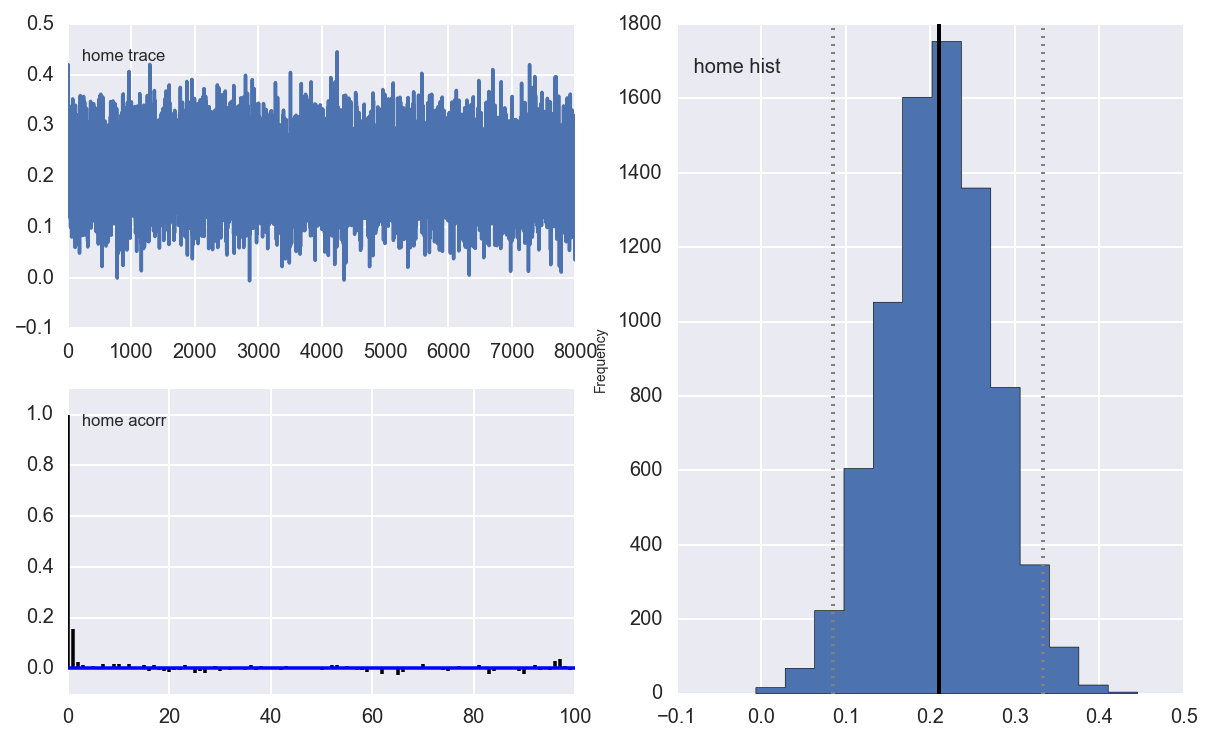

In [155]:
pymc.Matplot.plot(home)

Plotting intercept


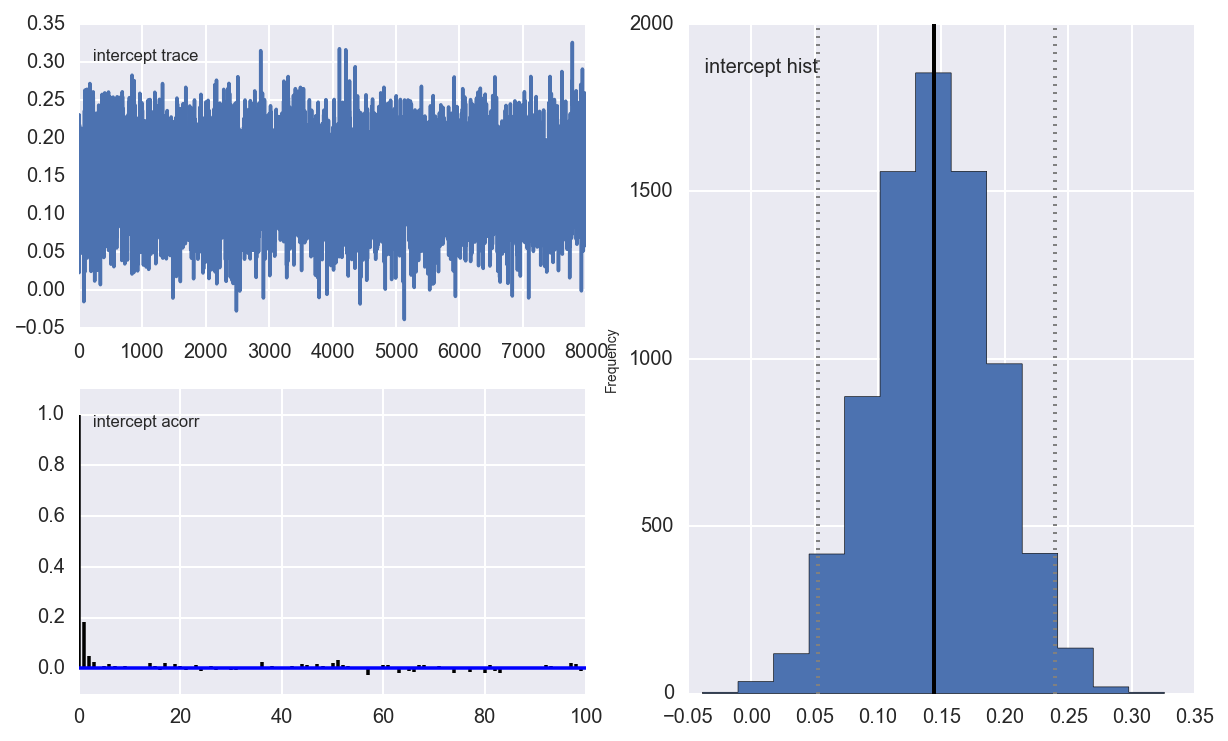

In [156]:
pymc.Matplot.plot(intercept)

Plotting tau_att


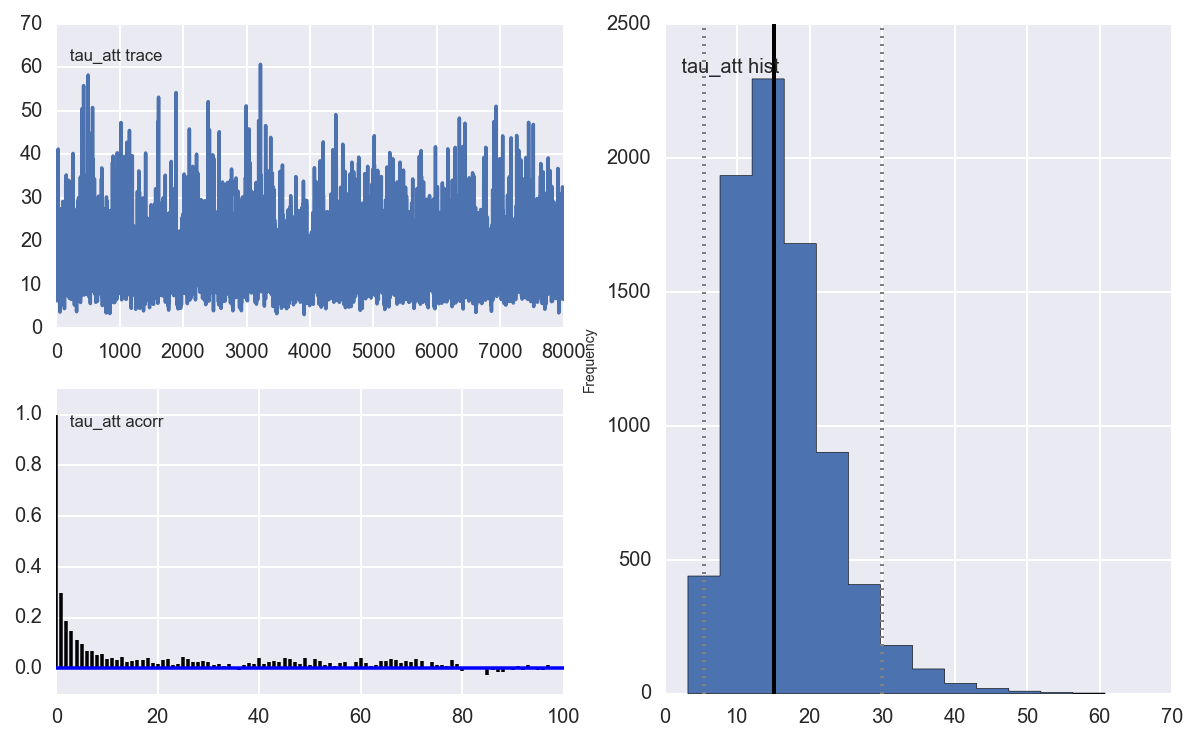

In [157]:
pymc.Matplot.plot(tau_att)

Plotting tau_def


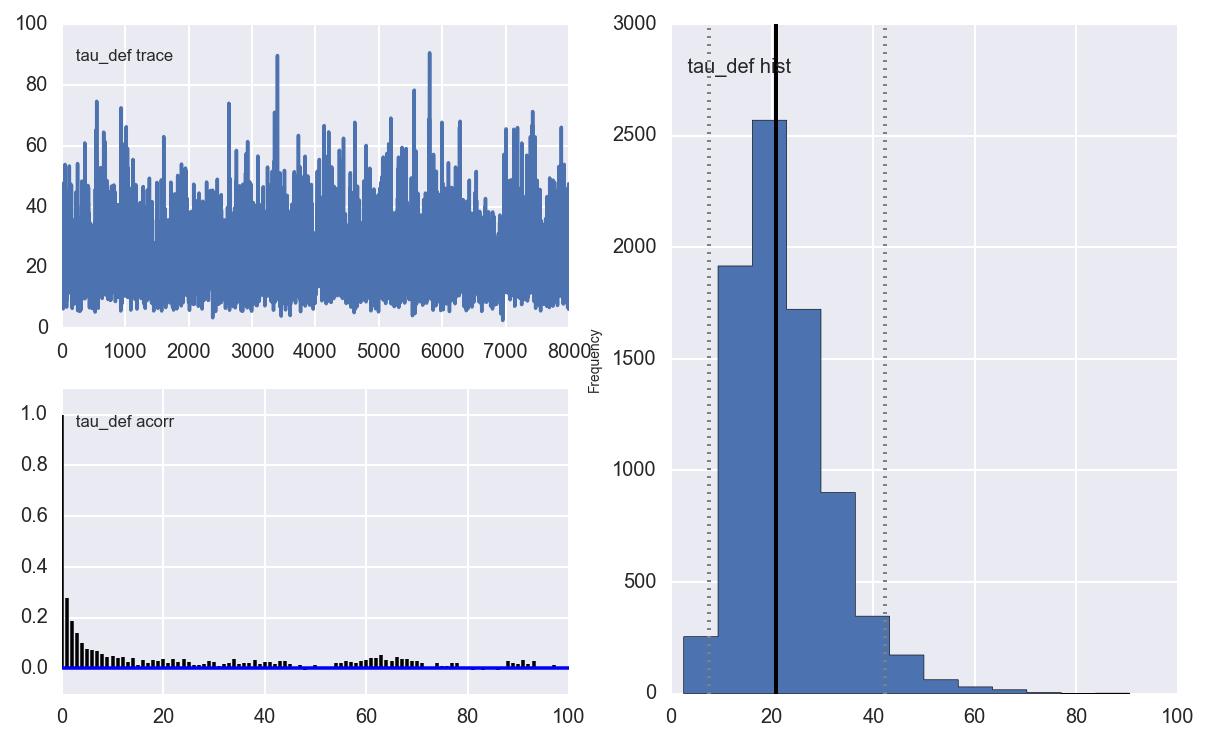

In [158]:
pymc.Matplot.plot(tau_def)

Plotting atts_0
Plotting atts_1
Plotting atts_2
Plotting atts_3
Plotting atts_4
Plotting atts_5
Plotting atts_6
Plotting atts_7
Plotting atts_8
Plotting atts_9
Plotting atts_10
Plotting atts_11
Plotting atts_12
Plotting atts_13
Plotting atts_14
Plotting atts_15
Plotting atts_16
Plotting atts_17
Plotting atts_18
Plotting atts_19


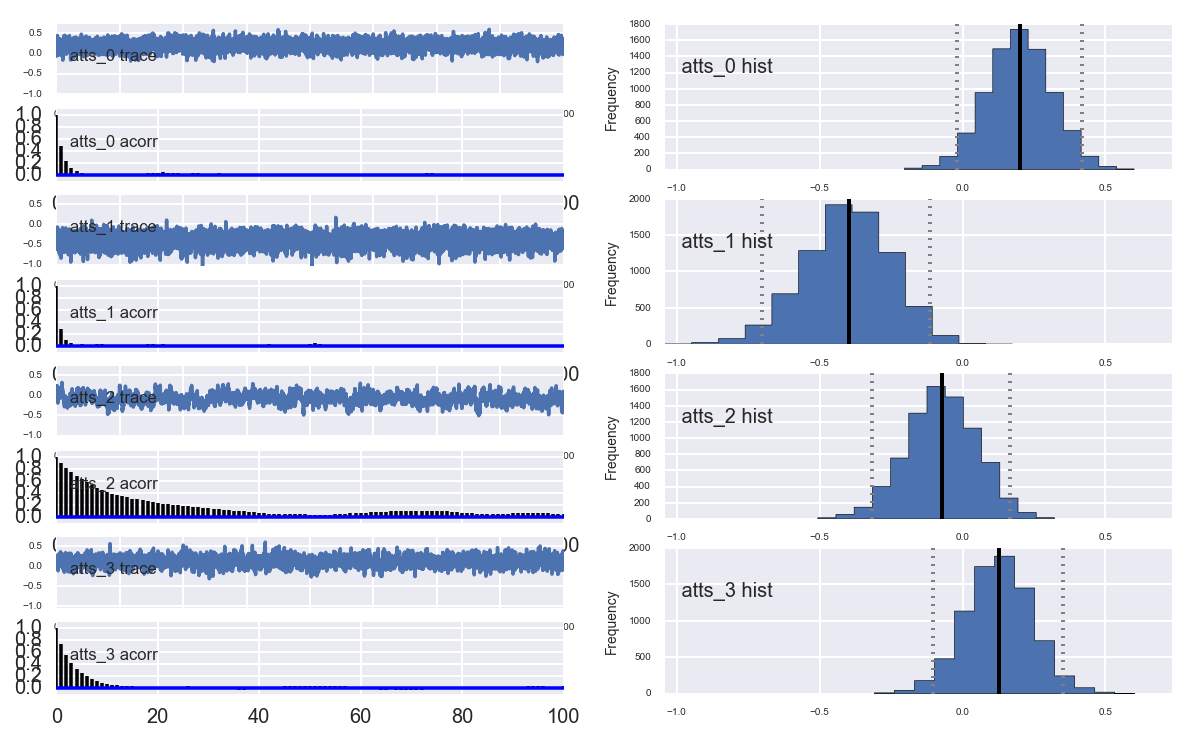

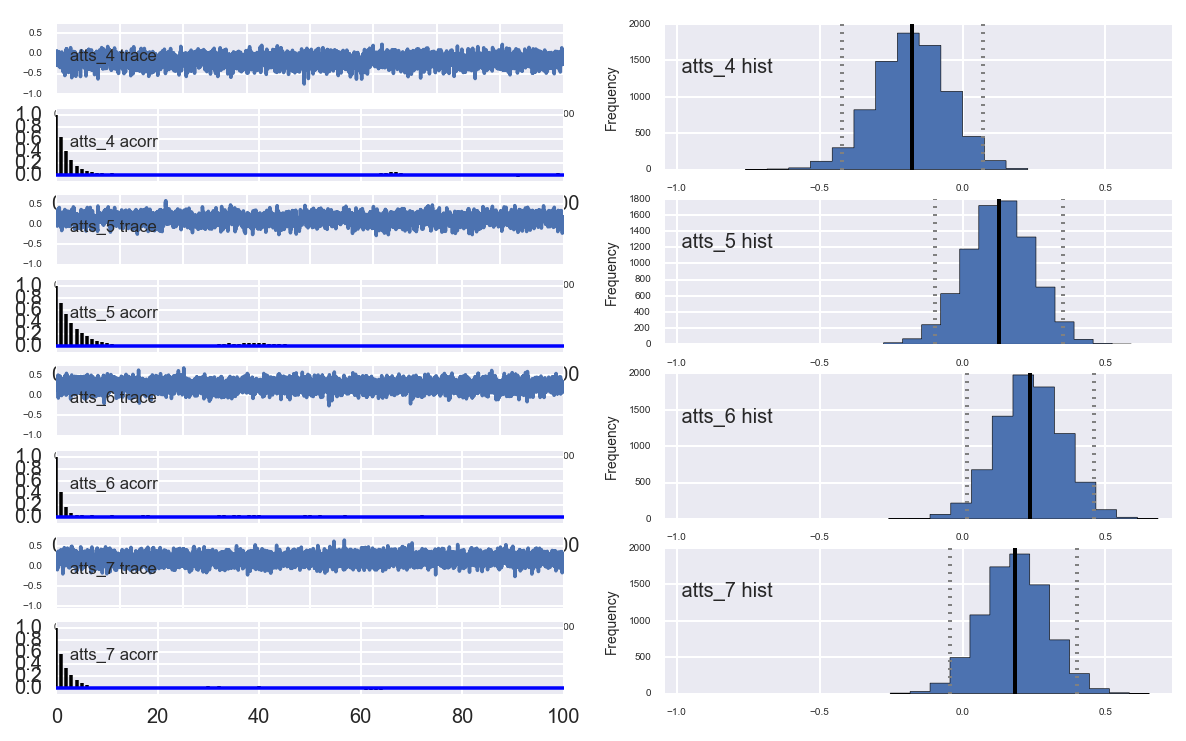

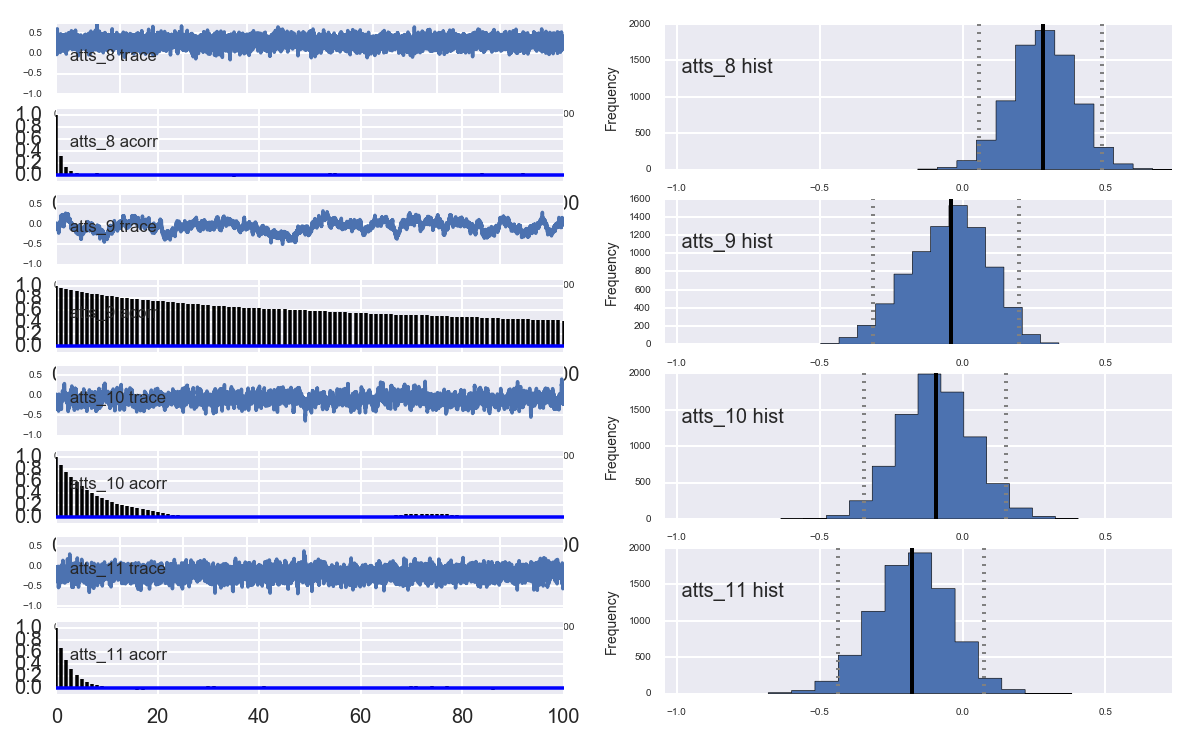

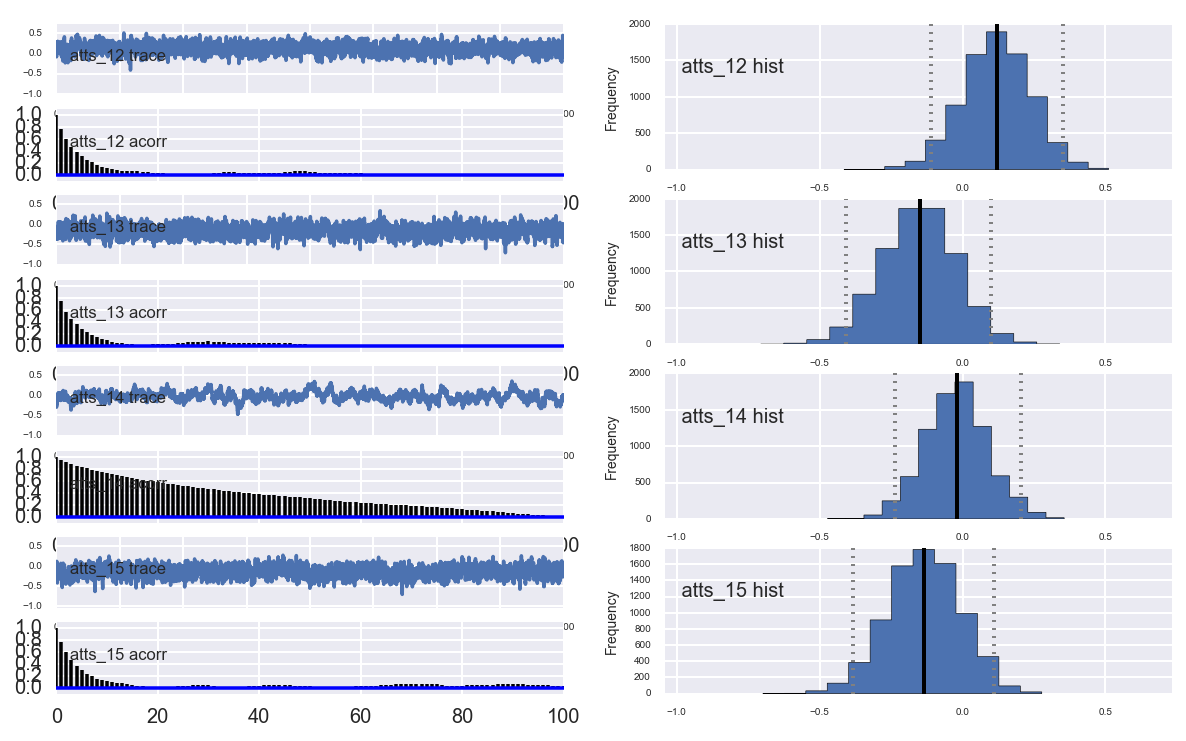

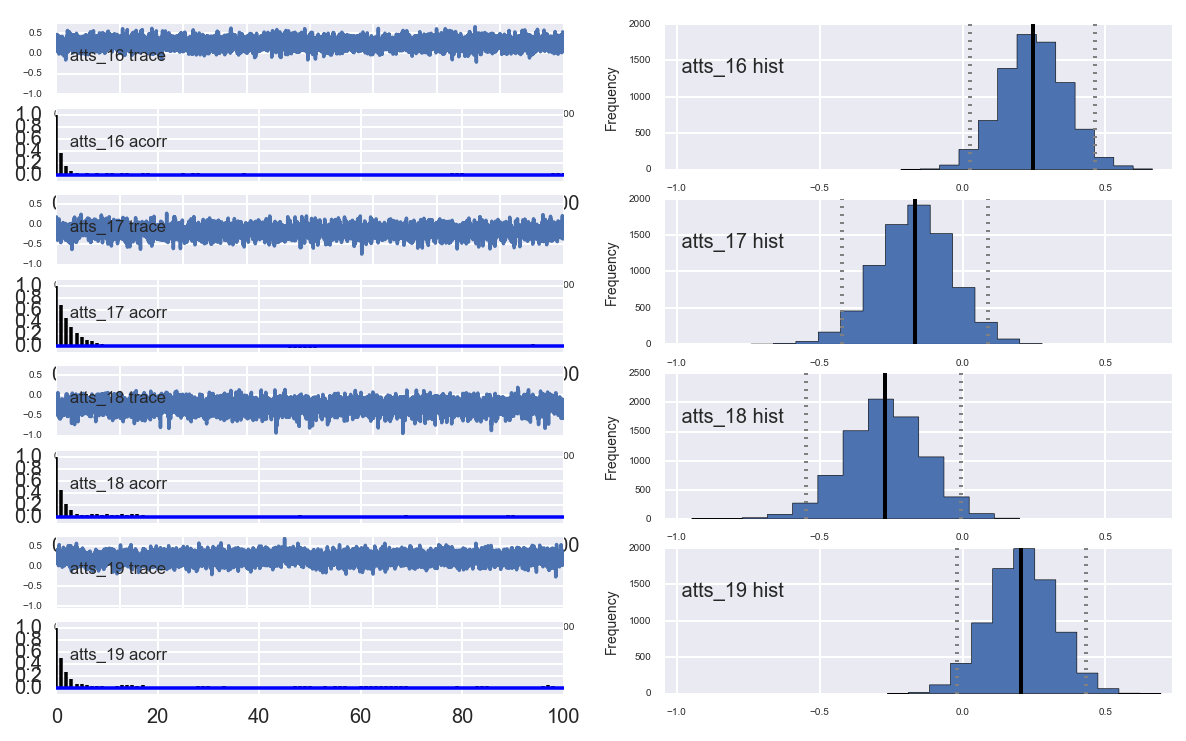

In [159]:
pymc.Matplot.plot(atts)
Embed = Image(CHART_DIR + 'atts.png')
Embed

In [160]:
data_file_table = DATA_DIR + 'premier_league_15_16_table.txt'
df_observed = pd.read_csv(data_file_table, sep='\t')
print(df_observed.columns.values)
df_observed = df_observed.drop(df_observed.columns.values[0], 1)
df_observed = df_observed.drop(df_observed.columns.values[0], 1)
df_observed = df_observed.drop(df_observed.columns.values[0], 1)
df_observed['QR']=''
df_observed.ix[0:3,'QR'] = "CL"
df_observed.ix[4:6,'QR'] = "EL"
df_observed.ix[17:19,'QR'] = "R"
df_observed.loc[df_observed.QR.isnull(), 'QR'] = ''
df_observed.rename(columns = {'CLUB ':'team'}, inplace = True)
print(df_observed.ix[1,1])
df_observed.head(40)

['POS ' 'Unnamed: 1' 'LP ' 'CLUB ' 'P ' 'W ' 'D ' 'L ' 'GF ' 'GA ' 'GD '
 'PTS']
38


,team,P,W,D,L,GF,GA,GD,PTS,QR
0,LEI,38,23,12,3,68,36,32,81,CL
1,ARS,38,20,11,7,65,36,29,71,CL
2,TOT,38,19,13,6,69,35,34,70,CL
3,MCI,38,19,9,10,71,41,30,66,CL
4,MUN,38,19,9,10,49,35,14,66,EL
5,SOU,38,18,9,11,59,41,18,63,EL
6,WHU,38,16,14,8,65,51,14,62,EL
7,LIV,38,16,12,10,63,50,13,60,
8,STK,38,14,9,15,41,55,-14,51,
9,CHE,38,12,14,12,59,53,6,50,


       avg_att   avg_def
ARS   0.177937  0.217472
AST  -0.387480 -0.264386
BOU  -0.070211 -0.209945
CHE   0.109711 -0.040754
CRY  -0.127802  0.002490
EVE   0.053674 -0.069979
LEI   0.218547  0.181275
LIV   0.103047  0.013089
MCI   0.256646  0.097038
MUN  -0.023723  0.248702
NEW  -0.136481 -0.144817
NOR  -0.171585 -0.182874
SOU   0.142452  0.123830
STK  -0.118891 -0.092683
SUN  -0.023215 -0.157696
SWA  -0.095845  0.008289
TOT   0.212557  0.163344
WAT  -0.117570  0.044627
WBA  -0.209068  0.048087
WHU   0.207301  0.014892


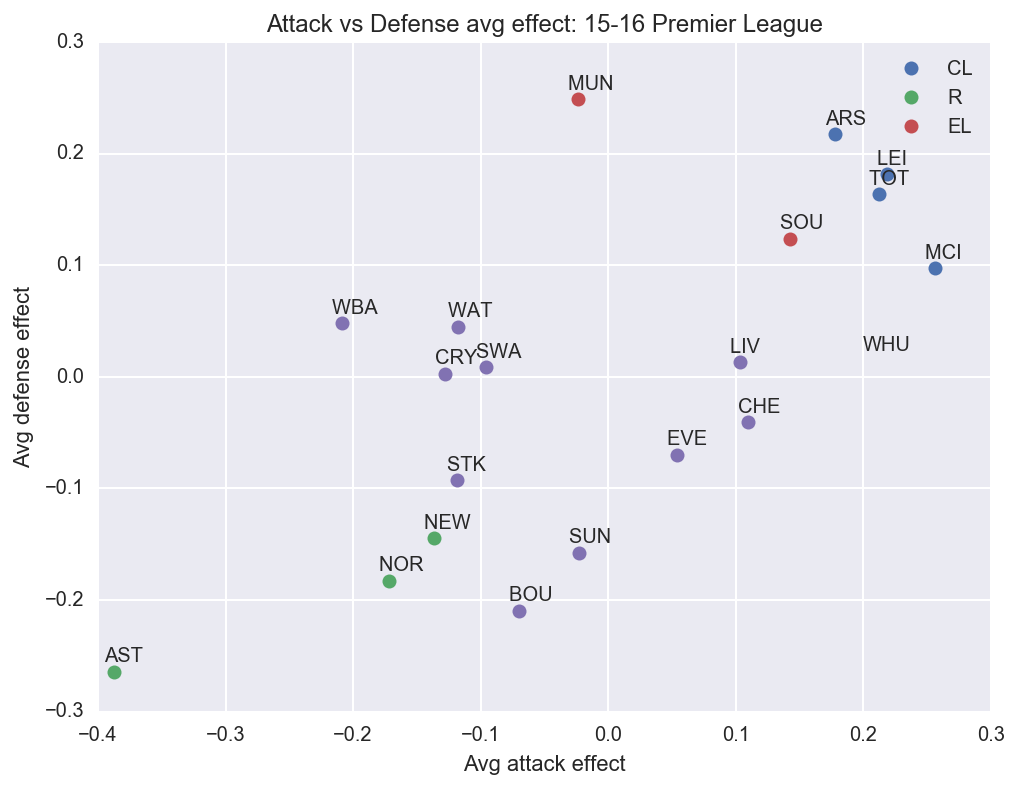

In [242]:
df_avg = pd.DataFrame({'avg_att': atts.stats()['mean'],
                       'avg_def': defs.stats()['mean']}, 
                      index=teams.team.values)
print(df_avg.head(30))
df_avg = pd.merge(df_avg, df_observed, left_index=True, right_on='team', how='left')
df_avg.head(30)
fig, ax = plt.subplots(figsize=(8,6))
for outcome in ['CL', 'R', 'EL', '']:
    ax.plot(df_avg.avg_att[df_avg.QR == outcome], 
            df_avg.avg_def[df_avg.QR == outcome], 'o', label=outcome)
    
for label, x, y in zip(df_avg.team.values, df_avg.avg_att.values, df_avg.avg_def.values):
    ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
ax.set_title('Attack vs Defense avg effect: 15-16 Premier League')
ax.set_xlabel('Avg attack effect')
ax.set_ylabel('Avg defense effect')
ax.legend()

In [299]:
df_avg.columns.values
df_avg.ix[1, 'team']
team1 = 'MUN '
team2 = 'CHE '
#df_avg.ix[df_avg.team==team1]
team1Index = df_avg[df_avg.team == team1].index[0]
team2Index = df_avg[df_avg.team == team2].index[0]

team1att = df_avg.ix[team1Index,'avg_att']
team1def = df_avg.ix[team1Index,'avg_def']
team2att = df_avg.ix[team2Index,'avg_att']
team2def = df_avg.ix[team2Index,'avg_def']

#print(team1att)
#print(team1def)
#print(team2att)
#print(team2def)

maximumDiff = 0.256646+0.264386
maximumDiff = 0.4
hometeambias = 0.2

teamRaw1Score = team1att - team2def
teamRaw2Score = team2att - team1def
print(teamRaw1Score, teamRaw2Score)
teamRaw1Score = (team1att - team2def)*(1+hometeambias)
teamRaw2Score = (team2att - team1def)*(1-hometeambias)
if teamRaw1Score <0: teamRaw1Score = 0
if teamRaw2Score <0: teamRaw2Score = 0
#print(teamRaw1Score)
#print(((teamRaw1Score)/maximumDiff)*5)
team1Score = int(round(((teamRaw1Score)/maximumDiff)*5))
team2Score = int(round(((teamRaw2Score)/maximumDiff)*5))
#team1Score = int(round(((0.1/teamRaw1Score))))
#team2Score = int(round(((0.1/teamRaw2Score))))

print(team1Score, team2Score)
print(team1+str(team1Score)+'-'+str(team2Score)+' '+team2)
#df_avg.iloc[1]['avg_att']

0.0170316373595 -0.138991277878
0 0
MUN 0-0 CHE 


[[ 0.01321418  0.36487134]
 [-0.62821543 -0.18134746]
 [-0.12394594 -0.0260857 ]
 [-0.05741243  0.31896717]
 [-0.33345552  0.12325271]
 [-0.11630108  0.11687069]
 [ 0.01562587  0.37797953]
 [-0.04477     0.17321867]
 [ 0.06763144  0.40983177]
 [-0.06579913  0.03597407]
 [-0.29919731 -0.07162744]
 [-0.35657058 -0.02168883]
 [ 0.05792934  0.25987729]
 [-0.20782737 -0.00779903]
 [-0.10638375  0.05695137]
 [-0.15453168  0.06283059]
 [ 0.09702935  0.32562318]
 [-0.23982086  0.20616158]
 [-0.29013634  0.01525231]
 [ 0.04601507  0.36630627]]


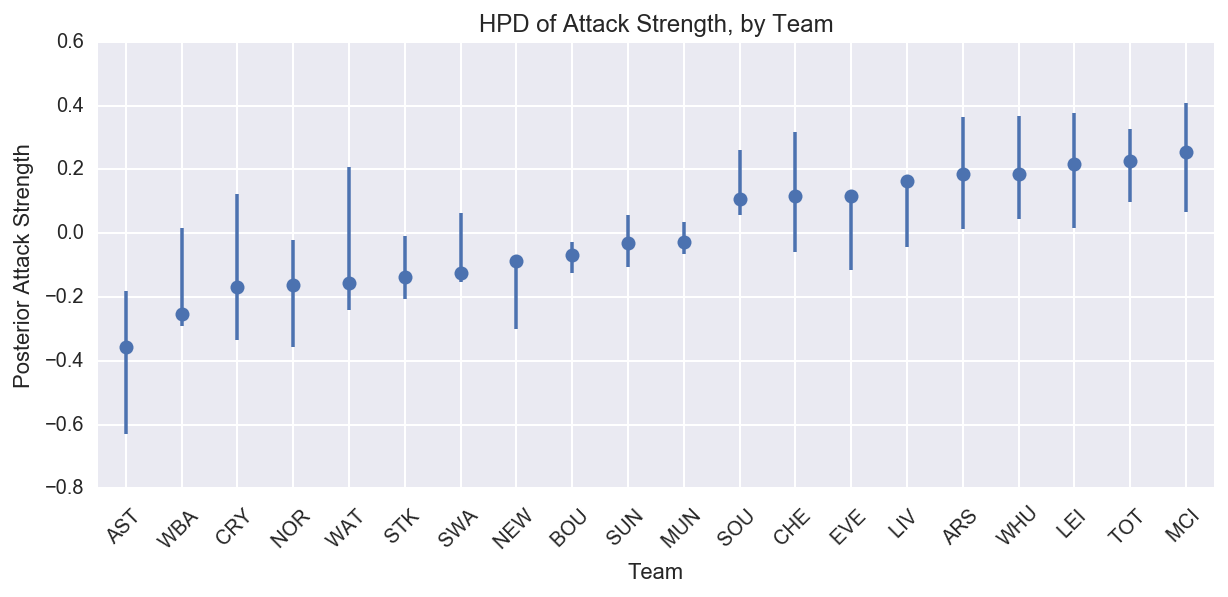

In [240]:
print(atts.stats()['95% HPD interval'].transpose())
df_hpd = pd.DataFrame(atts.stats()['95% HPD interval'].transpose(), 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(atts.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

In [114]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins * 3 + df.draws
    df['gf'] = df.home_goals + df.away_goals
    df['ga'] = df.home_goals_against + df.away_goals_against
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_CL'] = (df.position < 5).astype(int)
    df['relegated'] = (df.position > 17).astype(int)
    return df  
    
def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [115]:
simuls = simulate_seasons(1000)

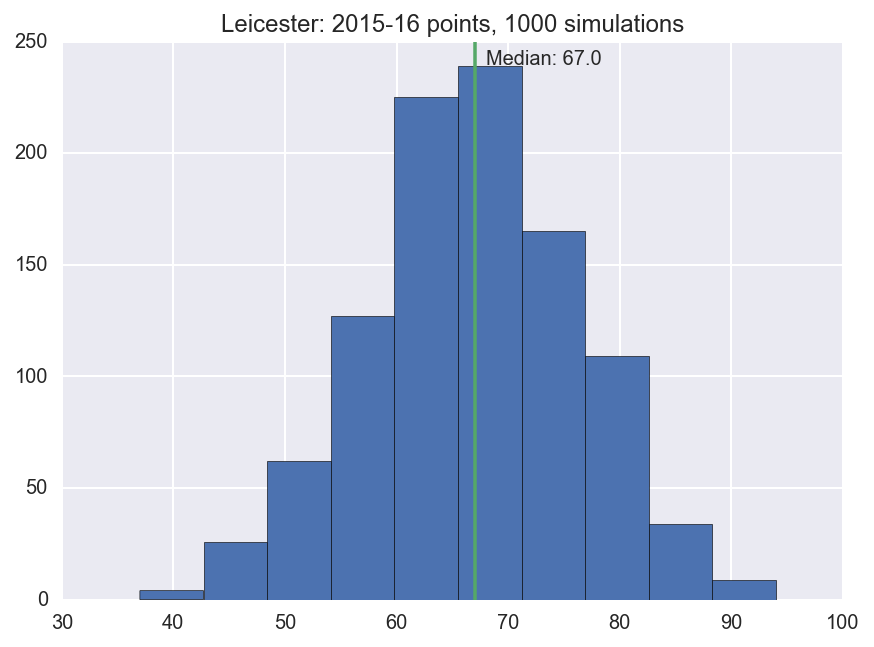

In [134]:
#print(simuls)
ax = simuls.points[simuls.team == 'MCI '].hist(figsize=(7,5))
median = simuls.points[simuls.team == 'MCI '].median()
#print(simuls.points[simuls.team == 'LEI '])
ax.set_title('Leicester: 2015-16 points, 1000 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

In [151]:
#simuls[['iteration'==0]]
print(simuls.columns.values)
simuls.ix[simuls.iteration==3]

#create_season_table(simuls)
#simuls

['index' 'team' 'i' 'home_draws' 'home_goals' 'home_goals_against'
 'home_losses' 'home_wins' 'away_draws' 'away_goals' 'away_goals_against'
 'away_losses' 'away_wins' 'wins' 'draws' 'losses' 'points' 'gf' 'ga' 'gd'
 'position' 'champion' 'qualified_for_CL' 'relegated' 'iteration']


,index,team,i,home_draws,home_goals,home_goals_against,home_losses,home_wins,away_draws,away_goals,...,losses,points,gf,ga,gd,position,champion,qualified_for_CL,relegated,iteration
60,6,LEI,6,3.0,35,11,2.0,14.0,3.0,36,...,7.0,81.0,71,27,44,1,1,1,0,3
61,13,STK,13,6.0,37,17,3.0,10.0,3.0,30,...,9.0,69.0,67,36,31,2,0,1,0,3
62,9,MUN,9,6.0,24,16,6.0,7.0,3.0,39,...,9.0,69.0,63,34,29,3,0,1,0,3
63,16,TOT,16,5.0,33,13,3.0,11.0,3.0,26,...,11.0,65.0,59,38,21,4,0,1,0,3
64,0,ARS,0,1.0,31,26,9.0,9.0,4.0,27,...,14.0,62.0,58,45,13,5,0,0,0,3
65,12,SOU,12,3.0,35,29,4.0,12.0,8.0,24,...,10.0,62.0,59,50,9,6,0,0,0,3
66,7,LIV,7,5.0,30,20,5.0,9.0,2.0,35,...,13.0,61.0,65,50,15,7,0,0,0,3
67,3,CHE,3,3.0,31,20,4.0,12.0,6.0,19,...,12.0,60.0,50,45,5,8,0,0,0,3
68,17,WAT,17,3.0,32,22,6.0,10.0,2.0,24,...,15.0,59.0,56,45,11,9,0,0,0,3
69,5,EVE,5,3.0,38,31,6.0,10.0,4.0,22,...,14.0,58.0,60,61,-1,10,0,0,0,3


,index,team,i,home_draws,home_goals,home_goals_against,home_losses,home_wins,away_draws,away_goals,...,draws,losses,points,gf,ga,gd,position,champion,qualified_for_CL,relegated
0,5,EVE,5,2.0,35,16,4.0,13.0,5.0,42,...,7.0,9.0,73.0,77,45,32,1,1,1,0
1,0,ARS,0,4.0,34,21,5.0,10.0,1.0,29,...,5.0,11.0,71.0,63,39,24,2,0,1,0
2,8,MCI,8,4.0,30,13,3.0,12.0,5.0,30,...,9.0,9.0,69.0,60,38,22,3,0,1,0
3,16,TOT,16,4.0,29,11,3.0,12.0,7.0,19,...,11.0,9.0,65.0,48,29,19,4,0,1,0
4,6,LEI,6,5.0,30,11,2.0,12.0,6.0,23,...,11.0,9.0,65.0,53,31,22,5,0,0,0
5,3,CHE,3,3.0,33,17,4.0,12.0,4.0,30,...,7.0,12.0,64.0,63,45,18,6,0,0,0
6,7,LIV,7,5.0,37,25,5.0,9.0,5.0,31,...,10.0,11.0,61.0,68,48,20,7,0,0,0
7,13,STK,13,4.0,29,27,7.0,8.0,2.0,19,...,6.0,15.0,57.0,48,48,0,8,0,0,0
8,12,SOU,12,2.0,30,15,5.0,12.0,6.0,15,...,8.0,14.0,56.0,45,40,5,9,0,0,0
9,14,SUN,14,6.0,23,13,4.0,9.0,3.0,17,...,9.0,15.0,51.0,40,47,-7,10,0,0,0
